## Lending Club Data Credit Risk Analysis - Predicting Defaults

## Introduction

For this project I chose a dataset from Lending Club approved personnal loans between 2007 and 2011. The data can be found on www.lendingclub.com. The purpose of the analysis is to improve profitablity and help the company and investors determine interest rates. We will use machine learning models to model credit risk as a binary classification problem.  

## Table of Content

- **Introduction**
- **Importing Libraries**
- **Creating Function**
    - Confusion Matrix plot
    - Feature importance plot
    - Rocurve plot
    - Minimum PCA
    - FPR and TPR
- **Exploratory Data Analysis**
    - Reading Data
    - Exploring Data
        -Target Column
        -Features Selection
    - Cleaning
        - Missing Values
        - Formating Numerical Data
        - Creating dummie variables for Categorical
- **Modeling** 
    - Selecting performance metrics
    - SMOT for class imbalance
    - Logistic Regression
    - SVM with PCA
    - Random Forest
    - XG Boost
- **Conclusion**
- **Next Steps**

## Importing Libraries

In [81]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score
from scipy import stats 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings

import itertools

from imblearn.over_sampling import SMOTE

%matplotlib inline
warnings.filterwarnings('ignore')

## Functions

In [82]:
#Function to plot confusion matrix
#------------------------------------------------------------------------------------------------------------------------------
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [83]:
#Plot Feature inportance
#---------------------------------------------------------------------------------------
def plot_feature_importances(model,X_train):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

In [84]:
def rocurve(logreg, X_train, X_test, y_train, y_test):
    
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline
    
    y_test_score = logreg.decision_function(X_test)
    y_train_score = logreg.decision_function(X_train)

    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)

    print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))
    print('train AUC: {}'.format(auc(train_fpr, train_tpr)))

    plt.figure(figsize=(10,8))
    lw = 2
    plt.plot(test_fpr, test_tpr, color='darkorange',
             lw=lw, label='Test ROC curve')
    plt.plot(train_fpr, train_tpr, color='blue',
             lw=lw, label='train ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [85]:
#Determining the number of dimensions to preserve given level of variance
#---------------------------------------------------------------------------------------------------------------------------
def find_min_pca(X_train, percentage=0.8):
    
    from sklearn.decomposition import PCA
    
    
    inital_components=pd.DataFrame(X_train).shape[1]
    if inital_components<10:
        print('The Data has less than 10 components, no PCA needed')
    else:
        a=int(str(inital_components)[-1])
        tens=int((inital_components-a)/10)
        for i in range(1,tens+1):
        
            
            
            pca = PCA(n_components=(i)*10)
            principalComponents = pca.fit_transform(X_train)
            explained_var= np.sum(pca.explained_variance_ratio_)
        
            
            
            if explained_var>=percentage:
                upper=i
                break
        
        

        for j in range((upper-1)*10,(upper)*10):
            pca = PCA(n_components=j)
            principalComponents = pca.fit_transform(X_train)                
            explained_var1= np.sum(pca.explained_variance_ratio_)
            if explained_var1>percentage:
                comp=j
                break
                    
                        
            
            
    return  comp  
    
   

In [329]:
#Determine FPR and TPR of a model
#---------------------------------------------------------------------------------------------------------------
def perf(y_test, y_pred):
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = round(fp  / (fp + tn),2)*100
    tpr= round(tp / (tp+fn),2)*100
    
    return(print(tpr,'% of the positives are appropriately identified, and ',fpr,'% of the negatives are appropriately identified.'))

## Exploratory Data Analysis

### - Raading the Data

In [284]:
data = pd.read_csv('loans_2007.csv')

print(data.shape)
data.head()

(42538, 52)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,171.62,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,119.66,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,649.91,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,357.48,Apr-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,67.79,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0


In [285]:
data.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens'],
      dtype='object')

### - Data Exploration

**Target Column**

In [286]:
data.loan_status.value_counts()

Fully Paid                                             33136
Charged Off                                             5634
Does not meet the credit policy. Status:Fully Paid      1988
Current                                                  961
Does not meet the credit policy. Status:Charged Off      761
Late (31-120 days)                                        24
In Grace Period                                           20
Late (16-30 days)                                          8
Default                                                    3
Name: loan_status, dtype: int64

**Fully Paid (33136):** Loan has been fully paid off.

**Charged Off (5634):** Loan for which there is no longer a reasonable expectation of further payments.

The target columns is labeled loan_status. The machine learning models we are going to build will aim to predict if the loan status is likely to be paid in full or not. Using a binary classifier, the successful outcome marked by a 1 is Fully paid for the loan status and the unsuccesful outcome marked by 0 is Charged Off for the loan status, all intermediary statuses won't be relevant for our analysis and these rows will be ignored.

In [287]:
data = data[(data['loan_status'] == 'Fully Paid') | (data['loan_status'] == 'Charged Off')]


In [288]:
data.loan_status.value_counts()

Fully Paid     33136
Charged Off     5634
Name: loan_status, dtype: int64

In [289]:
#Converting to binary data
#-----------------------------------------------------------------------------------------------------------------------------
data.loan_status[(data['loan_status']  == 'Fully Paid')]=0
data.loan_status[(data['loan_status']  == 'Charged Off')]=1

In [290]:
data.loan_status.astype(float)

0        0.0
1        1.0
2        0.0
3        0.0
5        0.0
6        0.0
7        0.0
8        1.0
9        1.0
10       0.0
11       0.0
12       1.0
13       0.0
14       1.0
15       0.0
16       0.0
17       0.0
18       0.0
19       0.0
20       0.0
21       1.0
22       0.0
23       0.0
24       1.0
25       0.0
26       1.0
27       1.0
28       0.0
29       0.0
30       0.0
        ... 
39756    0.0
39757    1.0
39758    0.0
39759    0.0
39760    0.0
39761    0.0
39762    0.0
39763    0.0
39764    0.0
39765    0.0
39766    0.0
39767    0.0
39768    0.0
39769    0.0
39770    0.0
39771    0.0
39772    0.0
39773    0.0
39774    0.0
39775    0.0
39776    0.0
39777    0.0
39778    0.0
39779    0.0
39780    0.0
39781    0.0
39782    0.0
39783    0.0
39784    0.0
39785    0.0
Name: loan_status, Length: 38770, dtype: float64

**Inspecting and selecting predictive columns**

In [291]:
len(data.columns)

52

Because of the high number of columns we will inspect the columns ten by ten for simplicity and to avoid potential human error while handling over 50 features manually at once.

In [292]:
#creating a lists to store columns we will retain as categorical or numerical
#------------------------------------------------------------------------
categorical_features=[]
numerical_features=[]

***_Columns 1 to 10:_***

In [293]:
data.columns[:10]

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade'],
      dtype='object')

In [294]:
for col in data.columns[:9]:
    print(col,'\n'*2,data[col].head(10),'\n'*3)

id 

 0     1077501
1     1077430
2     1077175
3     1076863
5     1075269
6     1069639
7     1072053
8     1071795
9     1071570
10    1070078
Name: id, dtype: object 



member_id 

 0     1296599.0
1     1314167.0
2     1313524.0
3     1277178.0
5     1311441.0
6     1304742.0
7     1288686.0
8     1306957.0
9     1306721.0
10    1305201.0
Name: member_id, dtype: float64 



loan_amnt 

 0      5000.0
1      2500.0
2      2400.0
3     10000.0
5      5000.0
6      7000.0
7      3000.0
8      5600.0
9      5375.0
10     6500.0
Name: loan_amnt, dtype: float64 



funded_amnt 

 0      5000.0
1      2500.0
2      2400.0
3     10000.0
5      5000.0
6      7000.0
7      3000.0
8      5600.0
9      5375.0
10     6500.0
Name: funded_amnt, dtype: float64 



funded_amnt_inv 

 0      4975.0
1      2500.0
2      2400.0
3     10000.0
5      5000.0
6      7000.0
7      3000.0
8      5600.0
9      5350.0
10     6500.0
Name: funded_amnt_inv, dtype: float64 



term 

 0      36 months
1      60

**Results for columns 1 to 10:** Some columns contain data which won't be useful to predict the outcome (like id or member id which are specific to clients record withthe lending isntitution)  while other contain information which is not yet available at the time loans are approved or denied (like funded amount), others like graed an subgrade seem to be providing the same input as interest rate but as a categorical rather than continuous variable, we won't retain any of the two.

**We retain:** 

**loan_amnt:** properly formated numerical feature

**installment:** properly formated numerical feature

**int_rate:** percentage sign needs to be removed and data turned into float

**term:** word 'months' needs to be removed


In [295]:
categorical_features.append('term')
numerical_features.append('loan_amnt')
numerical_features.append('installment')
numerical_features.append('int_rate')

***_Columns 11 to 20:_***

In [296]:
data.columns[10:20]

Index(['emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'purpose', 'title'],
      dtype='object')

In [297]:
for col in data.columns[10:20]:
    print(col,'\n'*2,data[col].head(10),'\n'*3)

emp_title 

 0                           NaN
1                         Ryder
2                           NaN
3           AIR RESOURCES BOARD
5          Veolia Transportaton
6     Southern Star Photography
7               MKC Accounting 
8                           NaN
9                     Starbucks
10        Southwest Rural metro
Name: emp_title, dtype: object 



emp_length 

 0     10+ years
1      < 1 year
2     10+ years
3     10+ years
5       3 years
6       8 years
7       9 years
8       4 years
9      < 1 year
10      5 years
Name: emp_length, dtype: object 



home_ownership 

 0     RENT
1     RENT
2     RENT
3     RENT
5     RENT
6     RENT
7     RENT
8      OWN
9     RENT
10     OWN
Name: home_ownership, dtype: object 



annual_inc 

 0     24000.0
1     30000.0
2     12252.0
3     49200.0
5     36000.0
6     47004.0
7     48000.0
8     40000.0
9     15000.0
10    72000.0
Name: annual_inc, dtype: float64 



verification_status 

 0            Verified
1     Source Verif

**For the same reasons as previously, we retain:**

**home_ownership:** will be turned into categorical

**annual_inc:** to be properly formated numerical feature

**purpose:** potential categorical

**emp_length** : seems to mean employment length and a potential good numerical feature

**verification_status** : categorical

In [298]:
categorical_features.append('home_ownership')
categorical_features.append('purpose')
categorical_features.append('verification_status')
numerical_features.append('emp_length')
numerical_features.append('annual_inc')

**Columns 21 to 30:**

In [299]:
data.columns[20:30]

Index(['zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util'],
      dtype='object')

In [300]:
for col in data.columns[20:30]:
    print(col,'\n'*2,data[col].head(10),'\n'*3)

zip_code 

 0     860xx
1     309xx
2     606xx
3     917xx
5     852xx
6     280xx
7     900xx
8     958xx
9     774xx
10    853xx
Name: zip_code, dtype: object 



addr_state 

 0     AZ
1     GA
2     IL
3     CA
5     AZ
6     NC
7     CA
8     CA
9     TX
10    AZ
Name: addr_state, dtype: object 



dti 

 0     27.65
1      1.00
2      8.72
3     20.00
5     11.20
6     23.51
7      5.35
8      5.55
9     18.08
10    16.12
Name: dti, dtype: float64 



delinq_2yrs 

 0     0.0
1     0.0
2     0.0
3     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
Name: delinq_2yrs, dtype: float64 



earliest_cr_line 

 0     Jan-1985
1     Apr-1999
2     Nov-2001
3     Feb-1996
5     Nov-2004
6     Jul-2005
7     Jan-2007
8     Apr-2004
9     Sep-2004
10    Jan-1998
Name: earliest_cr_line, dtype: object 



inq_last_6mths 

 0     1.0
1     5.0
2     2.0
3     1.0
5     3.0
6     1.0
7     2.0
8     2.0
9     0.0
10    2.0
Name: inq_last_6mths, dtype: float64 



open_acc 

 0

**For the same reasons as previously, we retain:**

**revol_util:** remove percentage sign and convert to float

**revol_bal :** properly formated numerical feature

**pub_rec:** turn to categorical

**open_acc :** properly formated numerical feature

**inq_last_6mths** : properly formated numerical feature

**earliest_cr_line** : turn to numerical because it would create too many dummy variables as categorical

**delinq_2yrs** : add as numerical

**dti**: properly formated numerical feature

In [301]:
numerical_features.append('pub_rec')
numerical_features.append('earliest_cr_line')
numerical_features.append('delinq_2yrs')
numerical_features.append('revol_util')
numerical_features.append('revol_bal')
numerical_features.append('open_acc')
numerical_features.append('inq_last_6mths')
numerical_features.append('dti')

**Columns 31 to 40:**

In [302]:
data.columns[30:40]

Index(['total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries'],
      dtype='object')

In [303]:
for col in data.columns[30:40]:
    print(col,'\n'*2,data[col].head(10),'\n'*3)

total_acc 

 0      9.0
1      4.0
2     10.0
3     37.0
5     12.0
6     11.0
7      4.0
8     13.0
9      3.0
10    23.0
Name: total_acc, dtype: float64 



initial_list_status 

 0     f
1     f
2     f
3     f
5     f
6     f
7     f
8     f
9     f
10    f
Name: initial_list_status, dtype: object 



out_prncp 

 0     0.0
1     0.0
2     0.0
3     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
Name: out_prncp, dtype: float64 



out_prncp_inv 

 0     0.0
1     0.0
2     0.0
3     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
Name: out_prncp_inv, dtype: float64 



total_pymnt 

 0      5863.155187
1      1008.710000
2      3005.666844
3     12231.890000
5      5632.210000
6     10137.840008
7      3939.135294
8       646.020000
9      1476.190000
10     7678.017673
Name: total_pymnt, dtype: float64 



total_pymnt_inv 

 0      5833.84
1      1008.71
2      3005.67
3     12231.89
5      5632.21
6     10137.84
7      3939.14
8       646.02
9    

**For the same reasons as previously, we retain:**

**total_acc:** properly formated numerical feature

**Columns 41 to 52:**

In [304]:
data.columns[41:]

Index(['last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens'],
      dtype='object')

In [305]:
for col in data.columns[40:]:
    print(col,'\n'*2,data[col].head(10),'\n'*3)

collection_recovery_fee 

 0     0.00
1     1.11
2     0.00
3     0.00
5     0.00
6     0.00
7     0.00
8     2.09
9     2.52
10    0.00
Name: collection_recovery_fee, dtype: float64 



last_pymnt_d 

 0     Jan-2015
1     Apr-2013
2     Jun-2014
3     Jan-2015
5     Jan-2015
6     May-2016
7     Jan-2015
8     Apr-2012
9     Nov-2012
10    Jun-2013
Name: last_pymnt_d, dtype: object 



last_pymnt_amnt 

 0      171.62
1      119.66
2      649.91
3      357.48
5      161.03
6     1313.76
7      111.34
8      152.39
9      121.45
10    1655.54
Name: last_pymnt_amnt, dtype: float64 



last_credit_pull_d 

 0     Jun-2016
1     Sep-2013
2     Jun-2016
3     Apr-2016
5     Jan-2016
6     May-2016
7     Dec-2014
8     Aug-2012
9     Mar-2013
10    Dec-2015
Name: last_credit_pull_d, dtype: object 



collections_12_mths_ex_med 

 0     0.0
1     0.0
2     0.0
3     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
Name: collections_12_mths_ex_med, dtype: float64 



policy_co

**For the same reasons as previously, we retain:**

**tax_liens:** numerical

**last_credit_pull_d** : turn to numerical because it would create too many dummy variables as categorical

**pub_rec_bankruptcies**: numerical

In [306]:
numerical_features.append('tax_liens')
numerical_features.append('last_credit_pull_d')
numerical_features.append('pub_rec_bankruptcies')

In [307]:
print('We have', len(categorical_features),'categorical_features and',len(numerical_features),'numerical_features')

We have 4 categorical_features and 16 numerical_features


In [308]:
categorical_features

['term', 'home_ownership', 'purpose', 'verification_status']

In [309]:
numerical_features

['loan_amnt',
 'installment',
 'int_rate',
 'emp_length',
 'annual_inc',
 'pub_rec',
 'earliest_cr_line',
 'delinq_2yrs',
 'revol_util',
 'revol_bal',
 'open_acc',
 'inq_last_6mths',
 'dti',
 'tax_liens',
 'last_credit_pull_d',
 'pub_rec_bankruptcies']

## - Cleaning

In [247]:
#First we deal with Nulls across the entire data set before treating numerical and categorical separately to avoid rows mismatch
#----------------------------------------------------------------------------------------------------------------------------
data.isna().sum()

index                            0
id                               0
member_id                        0
loan_amnt                        0
funded_amnt                      0
funded_amnt_inv                  0
term                             0
int_rate                         0
installment                      0
grade                            0
sub_grade                        0
emp_title                     1370
emp_length                       0
home_ownership                   0
annual_inc                       0
verification_status              0
issue_d                          0
loan_status                      0
pymnt_plan                       0
purpose                          0
title                           10
zip_code                         0
addr_state                       0
dti                              0
delinq_2yrs                      0
earliest_cr_line                 0
inq_last_6mths                   0
open_acc                         0
pub_rec             

Out of the columns we retained as features for modelling, the only ones that present NaN values are tax_liens, pub_rec_bankruptcies, revol_util and emp_length. tax_liens and revol_utill present a very loan number of null values and can be dropped without concern. Dropping emp_length and pub_rec_bankruptcies can increase the potential class imbalance that the data seems to be already exhibiting.

In [248]:
#Dropping tax_liens and revol_util NaN rows
#-------------------------------------------------------------------------------------------------------------------------------
data.dropna(subset=['tax_liens','revol_util','last_credit_pull_d'],inplace=True)

**Can we drop rows where emp_length is null?**

In [249]:
data.loan_status[data.emp_length.isna()==True].value_counts()

Series([], Name: loan_status, dtype: int64)

Out of the 5634 loans that were cahrged off, 228 or 4% occured on rows where we don't have information on employment length, we can afford to drop 4% of the rows with loans charged off without significant impact on class imbalance.

**Can we drop rows where pub_rec_bankruptcies is null?**

In [250]:
data.loan_status[data.pub_rec_bankruptcies.isna()==True].value_counts()

Series([], Name: loan_status, dtype: int64)

Out of the 5634 loans that were charged off, 117 or 2% occured on rows where we don't have information on bankruptcy, we can afford to drop 2% of the rows with loans charged off without significant impact on class imbalance.

In [251]:
data.dropna(subset=['pub_rec_bankruptcies','emp_length'],inplace=True)

In [252]:
data.reset_index(inplace=True)

In [253]:
#Creating a DataFrame for the Categorical Data
#-----------------------------------------------------------------------------------------------------------------------------
data_categorical=pd.DataFrame()
for col in categorical_features:
    data_categorical=pd.concat([ data_categorical, data[col]], axis= 1)

data_categorical.head()

,term,home_ownership,purpose,verification_status
0,36 months,RENT,credit_card,Verified
1,60 months,RENT,car,Source Verified
2,36 months,RENT,small_business,Not Verified
3,36 months,RENT,other,Source Verified
4,36 months,RENT,wedding,Source Verified


In [254]:
#Creating a DataFrame for the Numerical Data
#-----------------------------------------------------------------------------------------------------------------------------
data_numerical=pd.DataFrame()
for col in numerical_features:
    data_numerical=pd.concat([ data_numerical, data[col]], axis= 1)

data_numerical.head()

,loan_amnt,installment,int_rate,emp_length,annual_inc,pub_rec,earliest_cr_line,delinq_2yrs,revol_util,revol_bal,open_acc,inq_last_6mths,dti,tax_liens,last_credit_pull_d,pub_rec_bankruptcies
0,5000.0,162.87,10.65%,10+ years,24000.0,0.0,Jan-1985,0.0,83.7%,13648.0,3.0,1.0,27.65,0.0,Jun-2016,0.0
1,2500.0,59.83,15.27%,< 1 year,30000.0,0.0,Apr-1999,0.0,9.4%,1687.0,3.0,5.0,1.00,0.0,Sep-2013,0.0
2,2400.0,84.33,15.96%,10+ years,12252.0,0.0,Nov-2001,0.0,98.5%,2956.0,2.0,2.0,8.72,0.0,Jun-2016,0.0
3,10000.0,339.31,13.49%,10+ years,49200.0,0.0,Feb-1996,0.0,21%,5598.0,10.0,1.0,20.00,0.0,Apr-2016,0.0
4,5000.0,156.46,7.90%,3 years,36000.0,0.0,Nov-2004,0.0,28.3%,7963.0,9.0,3.0,11.20,0.0,Jan-2016,0.0


In [255]:
#checking Nulls for numerical features to make sure we didn't forget any
#--------------------------------------------------------------------------------------------------------------------------------
data_numerical.isna().sum()

loan_amnt               0
installment             0
int_rate                0
emp_length              0
annual_inc              0
pub_rec                 0
earliest_cr_line        0
delinq_2yrs             0
revol_util              0
revol_bal               0
open_acc                0
inq_last_6mths          0
dti                     0
tax_liens               0
last_credit_pull_d      0
pub_rec_bankruptcies    0
dtype: int64

In [256]:
#Removing percentage sign from revol_util column:
#-----------------------------------------------------------------------------------------------------------------------------
data_numerical['revol_util']=data_numerical['revol_util'].str.strip('%').astype(float)

In [257]:
#Removing percentage sign from int_rate column:
#-----------------------------------------------------------------------------------------------------------------------------
data_numerical['int_rate']=data_numerical['int_rate'].str.strip('%').astype(float)

In [258]:
#Converting dates to numerical because as categorical they would generate too many dummie variables
#------------------------------------------------------------------------------------------------------------------------------
for col in ['last_credit_pull_d', 'earliest_cr_line']:
    data_numerical[col] = pd.DatetimeIndex(data_numerical[col]).astype(np.int64)*1e-9

In [259]:
#Dealing with the employmebt length column
#-------------------------------------------------------------------------------------------------------------------------------
data_numerical.emp_length.unique()

array(['10+ years', '< 1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '1 year', '6 years', '2 years', '7 years'],
      dtype=object)

In [260]:
#Converting to numerical
#-----------------------------------------------------------------------------------------------------------------------------
mapping_dict = {
    'emp_length': {
        '10+ years': 10,
        '9 years': 9,
        '8 years': 8,
        '7 years': 7,
        '6 years': 6,
        '5 years': 5,
        '4 years': 4,
        '3 years': 3,
        '2 years': 2,
        '1 year': 1,
        '< 1 year': 0,
    }
}

data_numerical.replace(mapping_dict, inplace=True)

In [261]:
data_numerical.head()

,loan_amnt,installment,int_rate,emp_length,annual_inc,pub_rec,earliest_cr_line,delinq_2yrs,revol_util,revol_bal,open_acc,inq_last_6mths,dti,tax_liens,last_credit_pull_d,pub_rec_bankruptcies
0,5000.0,162.87,10.65,10,24000.0,0.0,4.733856e+08,0.0,83.7,13648.0,3.0,1.0,27.65,0.0,1.464739e+09,0.0
1,2500.0,59.83,15.27,0,30000.0,0.0,9.229248e+08,0.0,9.4,1687.0,3.0,5.0,1.00,0.0,1.377994e+09,0.0
2,2400.0,84.33,15.96,10,12252.0,0.0,1.004573e+09,0.0,98.5,2956.0,2.0,2.0,8.72,0.0,1.464739e+09,0.0
3,10000.0,339.31,13.49,10,49200.0,0.0,8.231328e+08,0.0,21.0,5598.0,10.0,1.0,20.00,0.0,1.459469e+09,0.0
4,5000.0,156.46,7.90,3,36000.0,0.0,1.099267e+09,0.0,28.3,7963.0,9.0,3.0,11.20,0.0,1.451606e+09,0.0


In [262]:
for col in data_numerical.columns:
    data_numerical[col].astype(float)

In [263]:
data_numerical.describe()

,loan_amnt,installment,int_rate,emp_length,annual_inc,pub_rec,earliest_cr_line,delinq_2yrs,revol_util,revol_bal,open_acc,inq_last_6mths,dti,tax_liens,last_credit_pull_d,pub_rec_bankruptcies
count,36989.000000,36989.000000,36989.000000,36989.000000,3.698900e+04,36989.000000,3.698900e+04,36989.000000,36989.000000,36989.000000,36989.000000,36989.000000,36989.00000,36989.0,3.698900e+04,36989.000000
mean,11172.230258,325.073393,11.999874,4.967477,6.945609e+04,0.054178,8.598158e+08,0.146152,48.999896,13381.643462,9.305848,0.869502,13.33784,0.0,1.411559e+09,0.041850
std,7383.992200,208.844669,3.707859,3.552827,6.396466e+04,0.235504,2.093383e+08,0.491792,28.310762,15844.117774,4.376308,1.067945,6.65307,0.0,5.408894e+07,0.200924
min,500.000000,16.080000,5.420000,0.000000,4.000000e+03,0.000000,-7.573824e+08,0.000000,0.000000,0.000000,2.000000,0.000000,0.00000,0.0,1.185926e+09,0.000000
25%,5500.000000,167.730000,8.940000,2.000000,4.120000e+04,0.000000,7.573824e+08,0.000000,25.600000,3730.000000,6.000000,0.000000,8.22000,0.0,1.370045e+09,0.000000
50%,10000.000000,280.610000,11.860000,4.000000,6.000000e+04,0.000000,8.992512e+08,0.000000,49.500000,8885.000000,9.000000,1.000000,13.43000,0.0,1.425168e+09,0.000000
75%,15000.000000,429.990000,14.540000,9.000000,8.300000e+04,0.000000,1.001894e+09,0.000000,72.500000,17043.000000,12.000000,1.000000,18.60000,0.0,1.464739e+09,0.000000
max,35000.000000,1305.190000,24.590000,10.000000,6.000000e+06,4.000000,1.225498e+09,11.000000,99.900000,149588.000000,44.000000,8.000000,29.99000,0.0,1.464739e+09,2.000000


## Categorical Data

In [264]:
data_categorical.isna().sum()

term                   0
home_ownership         0
purpose                0
verification_status    0
dtype: int64

In [265]:
data_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36989 entries, 0 to 36988
Data columns (total 4 columns):
term                   36989 non-null object
home_ownership         36989 non-null object
purpose                36989 non-null object
verification_status    36989 non-null object
dtypes: object(4)
memory usage: 1.1+ MB


In [266]:
for col in data_categorical.columns:
    print(col,'\n'*2,data_categorical[col].unique(),'\n'*3)

term 

 [' 36 months' ' 60 months'] 



home_ownership 

 ['RENT' 'OWN' 'MORTGAGE' 'OTHER'] 



purpose 

 ['credit_card' 'car' 'small_business' 'other' 'wedding'
 'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
 'moving' 'vacation' 'house' 'renewable_energy' 'educational'] 



verification_status 

 ['Verified' 'Source Verified' 'Not Verified'] 





In [267]:
#application type and tax_lien columns have only one value
#-----------------------------------------------------------------------------------------------------------------------------
data_numerical.drop(columns='tax_liens',axis=1, inplace=True)

In [268]:
data_categorical.head()

,term,home_ownership,purpose,verification_status
0,36 months,RENT,credit_card,Verified
1,60 months,RENT,car,Source Verified
2,36 months,RENT,small_business,Not Verified
3,36 months,RENT,other,Source Verified
4,36 months,RENT,wedding,Source Verified


In [269]:
#creating dummy variables
#------------------------------------------------------------------------------------------------------------------------------
for col in data_categorical.columns:
    dummies = pd.get_dummies(data_categorical[col])
    dummies.drop(dummies.columns[-1],axis=1,inplace=True)# dropping one of each to reduce multicoloniearity
    data_categorical = pd.concat([data_categorical, dummies], axis=1)
    data_categorical.drop(col, axis=1, inplace=True)  

In [270]:
data_categorical.head()

,36 months,MORTGAGE,OTHER,OWN,car,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,Not Verified,Source Verified
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [271]:
for col in data_categorical.columns:
    data_categorical[col].astype(int)

In [272]:
#Scaling
#------------------------------------------------------------------------------------------------------------------------------
scaler = StandardScaler()
scaled_num = pd.DataFrame(scaler.fit_transform(data_numerical),columns=data_numerical.columns)

#combining numercial and categorical in one data frame containing all feature that will be used during Modelling stage
#------------------------------------------------------------------------------------------------------------------------------
X=pd.concat([scaled_num,data_categorical],axis=1)
#------------------------------------------------------------------------------------------------------------------------------
y=data.loan_status
print(X.shape, y.shape)
X.head()

(36989, 34) (36989,)


,loan_amnt,installment,int_rate,emp_length,annual_inc,pub_rec,earliest_cr_line,delinq_2yrs,revol_util,revol_bal,...,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,Not Verified,Source Verified
0,-0.835905,-0.776681,-0.364063,1.416503,-0.710653,-0.230056,-1.845986,-0.297185,1.225703,0.016811,...,0,0,0,0,0,0,0,0,0,0
1,-1.174480,-1.270068,0.881956,-1.398195,-0.616850,-0.230056,0.301473,-0.297185,-1.398777,-0.738116,...,0,0,0,0,0,0,0,0,0,1
2,-1.188022,-1.152755,1.068050,1.416503,-0.894320,-0.230056,0.691507,-0.297185,1.748479,-0.658022,...,0,0,0,0,0,0,1,0,1,0
3,-0.158755,0.068169,0.401888,1.416503,-0.316680,-0.230056,-0.175235,-0.297185,-0.989033,-0.491271,...,0,0,0,0,1,0,0,0,0,1
4,-0.835905,-0.807374,-1.105740,-0.553785,-0.523047,-0.230056,1.143865,-0.297185,-0.731177,-0.342002,...,0,0,0,0,0,0,0,0,0,1


## SMOT for Class Imbalance - Synthetic Minority Oversampling

In [273]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
y_test=list(y_test)

In [274]:
print(y_train.value_counts()) #Previous original class distribution
X_train_resampled, y_train_resampled = SMOTE().fit_sample(X_train, y_train) 
print(pd.Series(y_train_resampled).value_counts()) #Preview synthetic sample class distribution
y_train_resampled=list(y_train_resampled)
y_train=list(y_train)

0    25392
1     4199
Name: loan_status, dtype: int64
1    25392
0    25392
dtype: int64


## Performance Metric Selection

The model will be used to determine who should be approved for a loan and who shouldnt, denying the loan to a client who will end up paying in full (false positives) represents a loss, but because interest is usually only a portion of principal the company will most likely be more confortbale not taking the chance when the risk is not to get reimbursed at all and lose the entire principal which represnets a higher amount. Thus the main concern here is to avoid approving somebody who won't be able to repay or in other words avoid false negatives. This is acheived by a model with a high recall rate. **Recall (or FPR) will be the performance evalution metric of chocie for our model. We also need to evalute TPR to make sure we are not declined too many qualified borrowers**

## Logistic Regression

In [330]:
model=LogisticRegression()
model.fit(X_train_resampled,y_train_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [331]:
y_pred=model.predict(X_test)

Confusion matrix, without normalization
[[4201 2124]
 [ 379  694]]


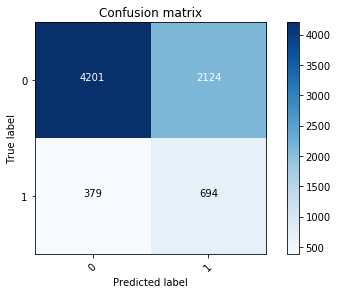

In [332]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=[0,1])

In [333]:
perf(y_test,y_pred)

65.0 % of the positives are appropriately identified, and  34.0 % of the negatives are appropriately identified.


Test AUC: 0.7143980343980344
train AUC: 0.7182368350216929


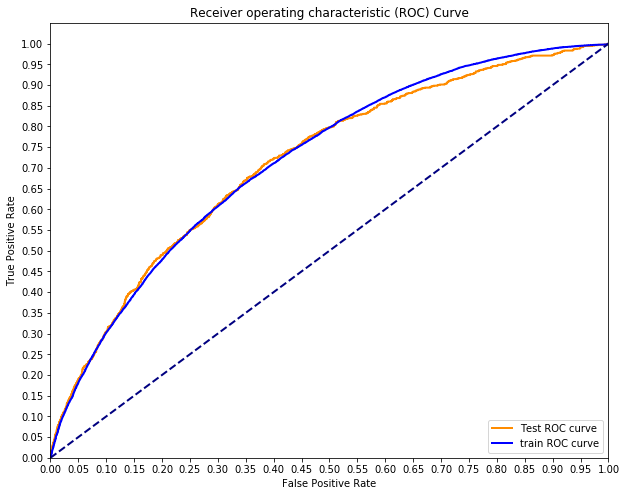

In [334]:
rocurve(model, X_train_resampled, X_test, y_train_resampled, y_test)

## Support Vector Machine

Lets use PCA to minimize computation time

In [338]:
#Finding the number of Principal Components to use to preserver 90% of variance 
#---------------------------------------------------------------------------------
min_comps=find_min_pca(X_train_resampled,0.9)
min_comps

13

In [339]:
#Verifying we are keeping the desired variance
#----------------------------------------------------------------------------------------------------------
pca = PCA(n_components=min_comps)
principalComponents = pca.fit_transform(X_train_resampled)
print(np.sum(pca.explained_variance_ratio_))

0.9058354902312984


In [340]:
model=Pipeline([('pca', PCA(n_components=min_comps)),('clf', svm.SVC(random_state=123))])
model.fit(X_train_resampled, y_train_resampled)
y_pred=model.predict(X_test)

Confusion matrix, without normalization
[[4508 1817]
 [ 425  648]]


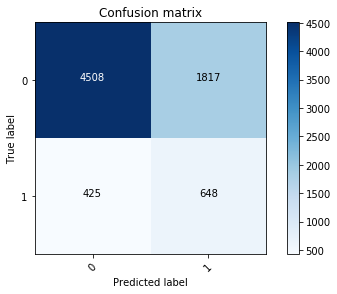

In [341]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=[0,1])

In [343]:
perf(y_test,y_pred)

60.0 % of the positives are appropriately identified, and  28.999999999999996 % of the negatives are appropriately identified.


## Random Forest

In [345]:
model=RandomForestClassifier()
model.fit(X_train_resampled, y_train_resampled)
y_pred=model.predict(X_test)

Confusion matrix, without normalization
[[6029  296]
 [ 867  206]]


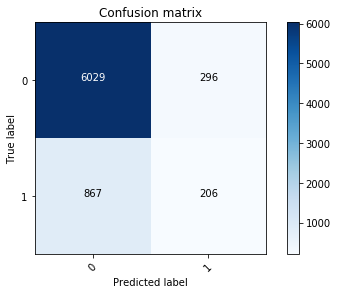

In [346]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=[0,1])

In [347]:
perf(y_test,y_pred)

19.0 % of the positives are appropriately identified, and  5.0 % of the negatives are appropriately identified.


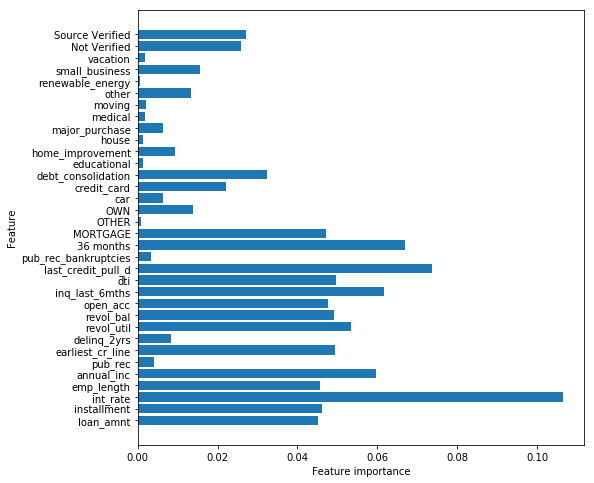

In [348]:
plot_feature_importances(model,X_train)

## XGBoost

In [1]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [2]:
model = xgb.XGBClassifier()
model.fit(X_train_resampled, y_train_resampled)
training_preds = model.predict(X_train_resampled)
X_test2=np.array(X_test)
y_pred = model.predict(X_test2)
training_accuracy = accuracy_score(y_train_resampled, training_preds)
val_accuracy = accuracy_score(y_test, y_pred)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))
perf(y_test,y_pred)

NameError: name 'X_train_resampled' is not defined

In [74]:
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [6,8],
    'min_child_weight': [7,8,10],
    'subsample': [ 0.7,0.9],
    'n_estimators': [5, 30, 100, 250],
}

In [75]:
grid_clf = GridSearchCV(model, param_grid, scoring='recall', cv=None, n_jobs=1)
grid_clf.fit(X_train_resampled, y_train_resampled)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

y_pred = grid_clf.predict(X_test2)


Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 8
min_child_weight: 8
n_estimators: 250
subsample: 0.9


Confusion matrix, without normalization
[[6060  265]
 [ 899  174]]


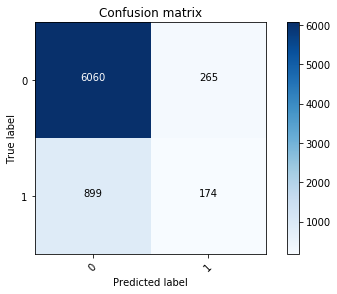

In [79]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=[0,1])

In [350]:
perf(y_test, y_pred)

19.0 % of the positives are appropriately identified, and  5.0 % of the negatives are appropriately identified.


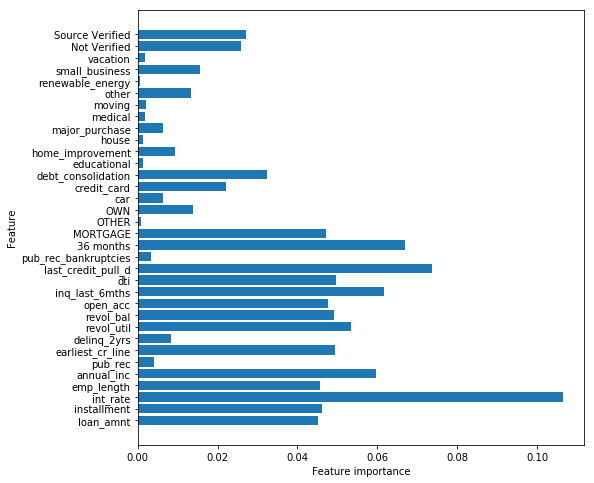

In [351]:
plot_feature_importances(model,X_train)

## Conclusion

- The logistic regression model gives us the best results by identifying 65% of the loans that won't be repaid but the downside is that the lender will only fund 34% of the loans that will be paid off. 

- Interest rate, date of last credit pull and length of the loan are the most important features in determining if a borrower will default


## Next Steps

- Work on class imbalance to improve predicting power of the model
- Determine levels of interest rates insuring profitability despites undetected defaults 
- Optimize Random Forest Hyperparameters to improve model 